# Data Preparation
First step like always, preparing the data before being used. We will do this by using standard libraries *numpy* and *pandas*. 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv


Then after that, we will review a bit about how the data look. By doing this, we can know a little bit more about how we are supposed to do with the data next. 

In [3]:
train = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv')
train.head(3)

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy


This data only has text and label. We can't get any information out of this, except if we wanted to read each rows of the text. But we want to know more about the relation of text column and label column. So, we decided to do sentiment analysis. 

**Sentiment analysis** is the analysis to identify how sentimental the texts are. There are two types of sentimental analysis, sentimental analysis based on the *polarity* and sentimental analysis based on the *subjectivity*. Well, you can say that sentiment analysis is something that is very useful to identify how emotional the writer when they wrote the text.   

In [4]:
import spacy
import re
from textblob import TextBlob

nlp = spacy.load('en_core_web_sm')

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

def polarity_and_subjectivity(x):
    a = re.findall(r'[\w\d]+', x)
    b = str()
    for i in a:
        b = b + str(' ') + str(i)
    c = polarity(b)
    d = subjectivity(b)
    return c, d

In [5]:
pols = []
subs = []

for t in train.text:
    pol, sub = polarity_and_subjectivity(t)
    pols.append(pol)
    subs.append(sub)
    
train['polarity'] = pols
train['subjectivity'] = subs

In [6]:
train.head(5)

,text,label,polarity,subjectivity
0,Just got back from seeing @GaryDelaney in Burs...,joy,0.366667,0.633333
1,Oh dear an evening of absolute hilarity I don'...,joy,0.283333,0.500000
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,-0.400000,0.400000
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.390000,0.490000
4,I feel so blessed to work with the family that...,joy,0.400000,0.350000


Right now, we got the data for polarity and subjectivity of each tweets. 

# Exploratory Data Analysis (EDA)
## Polarity and Subjectivity of Each Emotions

After getting the polarity and subjectivity of each tweets, we will analyze all these values based on the emotions they are related to. We will see, how emotions affect the polarity and subjectivity. 

<Figure size 360x1440 with 0 Axes>

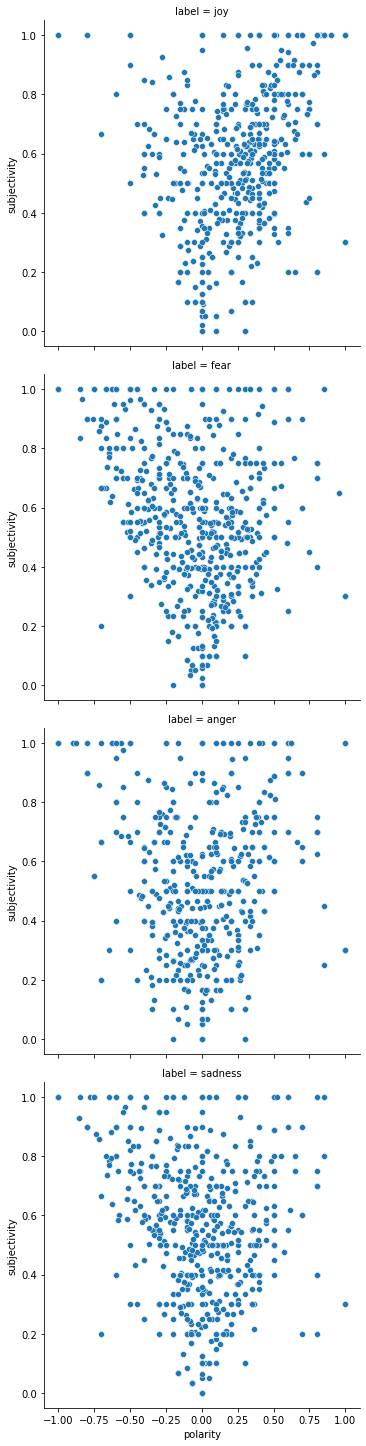

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 20))
sns.relplot(data=train, x='polarity', y='subjectivity', row='label')

From the plot above, not so many things that we can take off because of the difference that is not so significant. If we see slightly, it almost like all of these plots don't have difference at all. Only when looked at this closely we finally realize that there are small difference that actually could be meaningful.

**Joy Emotions**
The people that are in joy emotion, they tend to be more positive. This positivity can be subjective though, it feels like the joy came from their own character, not necessarily because of what happen in their life. You can see that there are more positive polarity than the negative. When the subjectivity is 1, there are also more positve polarity.

**Fear Emotions**
In fear, people tend to more negative. Sometime, they can have positivity (remember, fear down't always relate to negativity), that's when they are less subjective, or I would say more objective.  At the scatter plot, you can see that most of the data are located on the center bottom, but there are more negative data than the positive data, signify that fear mostly comes from negativity.

**Anger Emotions**
In anger emotions, there are no particular pattern. You can be postive and angry, but you also can be negative and angry. The reason why someone became angry can also be sujective and negative. 

**Sad Emotions**
In sad, we can be more negative. It showed at the plot, that there are slightly more data at the left side of the plot. 

# Data Processing

Next thing we need to do is processing the data, so then we can feed them to the machine learning model that we will build. Because this is a text data, we will be using **regular expression** and **spacy**, a library in python that is specialized to analyze text. 

In [8]:
def words_reduction(x):
    a = re.findall(r'[\w\d]+', x)
    b = str()
    for i in a:
        b = b + str(' ') + str(i)
    return b

def searching_vector(x):
    nlp_x = nlp(x)
    vec_x = nlp_x.vector
    if len(vec_x) == 0:
        vec_x = np.zeros([1, 96])
    return vec_x

def get_words_vector(x):
    text_vector = searching_vector(words_reduction(x[0]))
    for t in x[1:]:
        new_vector = searching_vector(words_reduction(t))
        text_vector = np.vstack((text_vector, new_vector))
    return text_vector

train_text_vector = get_words_vector(train.text)

Our objective in this project is to understand the emotions more and to build a model that can predict the emotion of a text or tweet specifically. If you wanna build a machine learning model that can predict something, yoiu can't use text as input. The text has to be preprocessed first. Turning it into numbers is the most common option. 

We can change this tweet from text to collection of numbers or vector. This vector is basically the center of every words vector on the tweet (each word has their own vector). After all of this process, the text data tha tight now in a form of vector can be useful for a machine learning model.  

In [9]:
from sklearn.preprocessing import LabelEncoder

target_transformer = LabelEncoder()
train_label_transformed = target_transformer.fit_transform(np.array(train.label).reshape(-1, 1))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [10]:
valid = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv')
valid.head(3)

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy


## First Try

In [11]:
valid_text_vector = get_words_vector(valid.text)
valid_label_transformed = target_transformer.transform(np.array(valid.label).reshape(-1, 1))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [13]:
models = [LogisticRegression(), GaussianNB(), SVC(), KNeighborsClassifier(),
          DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
model_names = ['Logistic Regression', 'Gaussian Naive-Bayes', 'SVC', 'K-Neighbors Classifier',
               'Decision Tree Classifier', 'Random Forest Classifier', 'Ada Boost Classifier']
scores = np.zeros([len(models), 1])

for i, m in enumerate(models):
    clf =  m.fit(train_text_vector, train_label_transformed)
    scores[i] = clf.score(valid_text_vector, valid_label_transformed)
    
scores = pd.DataFrame(scores, columns=['score'], index=model_names)
scores

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,score
Logistic Regression,0.342939
Gaussian Naive-Bayes,0.288184
SVC,0.308357
K-Neighbors Classifier,0.296830
Decision Tree Classifier,0.273775
Random Forest Classifier,0.308357
Ada Boost Classifier,0.314121


We are using several machine learning models here to find out which model that has the best performance. The best one that we can get will be used for further use. 

From the table above, you can see that there is no model that has a satisfying performance. The highest score that we can get is 34%, which means when this model predict they tend to have more mistakes than the right predictions. From this take, we know that we need to make some adjustments. 

In [14]:
from sklearn.preprocessing import OneHotEncoder

oh_transformer = OneHotEncoder()
train_oh_label = oh_transformer.fit_transform(np.array(train.label).reshape(-1, 1))
train_oh_label = train_oh_label.toarray()

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='relu'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [16]:
model.fit(train_text_vector, train_oh_label, epochs=30, batch_size=42)

Epoch 1/30
87/87 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.2278
Epoch 2/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2364
Epoch 3/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2480
Epoch 4/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2376
Epoch 5/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2322
Epoch 6/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2301
Epoch 7/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2337
Epoch 8/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2460
Epoch 9/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2300
Epoch 10/30
87/87 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2269
Epoch 11/30
87/87 [==============================

We also tried to use deep learning which gives another bad results. 

## Second Try

This time, we would try to eliminate some of the words from the tweets. Our assumption is, there are so many words that are not important in the tweets, so it moved the vector to certain position that is not really represent the meaning of the tweet. We would only choose:
1. Adjective
2. Verb
3. Noun

We believe that these are part of the sentences or in this case tweet, that give meaning. By understanding these three parts, we could easily understand the whole meaning of a sentence. Especially if we fed this to a machine, which has no intuition about grammar.  

In [17]:
def get_the_parts(txt):
    long = len(txt)
    important = ['ADJ', 'VERB', 'NOUN']
    the_parts = []
    for t in txt:
        if t.pos_ in important:
            the_parts.append(str(t))
    parts_text = str()
    for t in the_parts:
        parts_text = parts_text + ' ' + t
    return parts_text

new_texts = [get_the_parts(nlp(words_reduction(x))) for x in train.text]
new_vec = get_words_vector(new_texts)

In [18]:
new_valids = [get_the_parts(nlp(words_reduction(x))) for x in valid.text]
new_valids_vec = get_words_vector(new_valids)

In [19]:
scores_2 = np.zeros([len(models), 1])

for i, m in enumerate(models):
    clf =  m.fit(new_vec, train_label_transformed)
    scores_2[i] = clf.score(new_valids_vec, valid_label_transformed)
    
scores_2 = pd.DataFrame(scores_2, columns=['score'], index=model_names)
scores_2

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,score
Logistic Regression,0.319885
Gaussian Naive-Bayes,0.308357
SVC,0.311239
K-Neighbors Classifier,0.331412
Decision Tree Classifier,0.276657
Random Forest Classifier,0.331412
Ada Boost Classifier,0.322767


## Third Try

Even after being selective with the words to proceed, we still have the same struggle. We don't think that we can make a good model by using word embeddings for this case. So, we just think about a more simple solution which is using **count vectorizer**. Well word embedding itself is already a vectorizer, but this time the vectorizer is specified only for this use, while word embedding is a word with its meaning but in a form of vector.  


In [20]:
sketch = new_texts
no_space = lambda x: x.lower()
new_texts = [no_space(x) for x in sketch]

sketch_valid = [words_reduction(x) for x in valid.text]
new_valid = [no_space(x) for x in sketch_valid]

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_text_cv = cv.fit_transform(new_texts)
valid_text_cv = cv.transform(new_valid)

train_text_cv = train_text_cv.toarray() 
valid_text_cv = valid_text_cv.toarray() 

In [22]:
scores_3 = np.zeros([len(models), 1])

for i, m in enumerate(models):
    clf =  m.fit(train_text_cv, train_label_transformed)
    scores_3[i] = clf.score(valid_text_cv, valid_label_transformed)
    
scores_3 = pd.DataFrame(scores_3, columns=['score'], index=model_names)
scores_3

,score
Logistic Regression,0.827089
Gaussian Naive-Bayes,0.527378
SVC,0.775216
K-Neighbors Classifier,0.414986
Decision Tree Classifier,0.789625
Random Forest Classifier,0.824207
Ada Boost Classifier,0.593660


From this, we can get the accuracy of 82% which came from Logistic Regression Performance. 

# Summary

1. Not so many distinctions can be seen by sentiment analysis from many different emotions, whether it is anger, fear, sad, or joy. 
2. Building a model that can classify emotions of tweets, from this project, we know that **word embeddings** is not a good idea. It is better to just use **count vectorizer**.
